### Comparing the Color of Quasars

Jenny Kim, Phil Marshall

[This file](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv) contains SDSS quasar magnitudes and redshifts. With the lenspop library, we could compute the synthetic magnitudes in G, R, I, and Z filter of the quasar samples in the file. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $G-R$ magnitude, 4) $R-I$ magnitude, and 5) $I-Z$ magnitude between the known SDSS values and the colored magnitudes for each quasar sample.

### Requirements

SDSS data(can be downloaded [here](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv)), packages that help reading and writing the data, [color_demo](https://github.com/jennykim1016/OM10/blob/master/notebooks/color_demo.py) to synthetically color the quasars.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# to interactively display the diagrams
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import color_demo
import pandas as pd
import corner
from astropy.table import Table
import numpy as np
from om10 import plotting
sns.set()
pd.set_option('display.max_columns', None)

First, let's read in the catalog through pd(panda) and remove any outliers.

In [3]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
# Change to Numpy Array because it is easier to manipulate
qso = qsos.as_matrix()

We initialize the array for redshift, $i$-magnitude, $G-R$ magnitude, $R-I$ magnitude, and $I-Z$ magnitude. Then, we select 50 random numbers from 0 to length of qso array, painting them with the color_demo file which extends lenspop library to compute the synthetic magnitude.

In [4]:
# color the quasars with the method written
z=[]
i=[]
gr=[]
ri=[]
iz=[]
# import the package 'random' to generate random numbers
import random
for number in range(50):
    # key : ra dec dered_u dered_g dered_r dered_i dered_z mag_u mag_g mag_r mag_i mag_z spec_z u_g_color g_r_color r_i color i_z carlar ...
    rand = random.randint(0, len(qso)-1)
    redshift = qso[rand][12]
    r_calc, g_calc, i_calc, z_calc = color_demo.CalculateMagnitude('../data/', 'source', redshift)
    g_r = g_calc-r_calc
    r_i = r_calc-i_calc
    i_z = i_calc-z_calc
    z.append(redshift)
    i.append(i_calc)
    gr.append(g_r)
    ri.append(r_i)
    iz.append(i_z)

Draw the cornerplot with the arguments in axis_labels and save it first so that we could overlap it with the second cornerplot. Two cornerplot seems a lot, but corner.corner automatically displays the cornerplot in jupyter. However, using %%capture stops jupyter displaying the cornerplot.

In [5]:
%%capture
#om10 uses usetex=True, which sometimes generates error when using matplotlib. To be safe, let's disable usetex.
matplotlib.rc('text', usetex=False)
data = Table({'MAGI_Q': i, 'ZSRC': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
axis_labels = {}
axis_labels['ZSRC'] = '$redshift$'
axis_labels['MAGI_Q'] = '$I$'
axis_labels['GR'] = '$G-R$'
axis_labels['RI'] = '$R-I$'
axis_labels['IZ'] = '$I-Z$'
features, labels = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
#fig1 saves the cornerplot of colored quasars.
fig1 = corner.corner(features, labels=labels, color='blue', smooth=1.0)

Get the original SDSS data of $i$-magnitudes, redshifts, $G-R$ magnitudes, $R-I$ magnitudes, and $I-Z$ magnitudes as an array. Remove outliers based on the redshift and the $i$-magnitude. 

In [14]:
i = qsos["mag_i"].as_matrix()
z = qsos["spec_z"].as_matrix()
gr = qsos["g_r_color"].as_matrix()
ri = qsos["r_i_color"].as_matrix()
iz = qsos["i_z_color"].as_matrix()

i = i[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
z = z[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
gr = gr[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
ri = ri[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]
iz = iz[(qsos["mag_i"].as_matrix()<23.6) & (qsos["spec_z"].as_matrix()<2.5)]

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

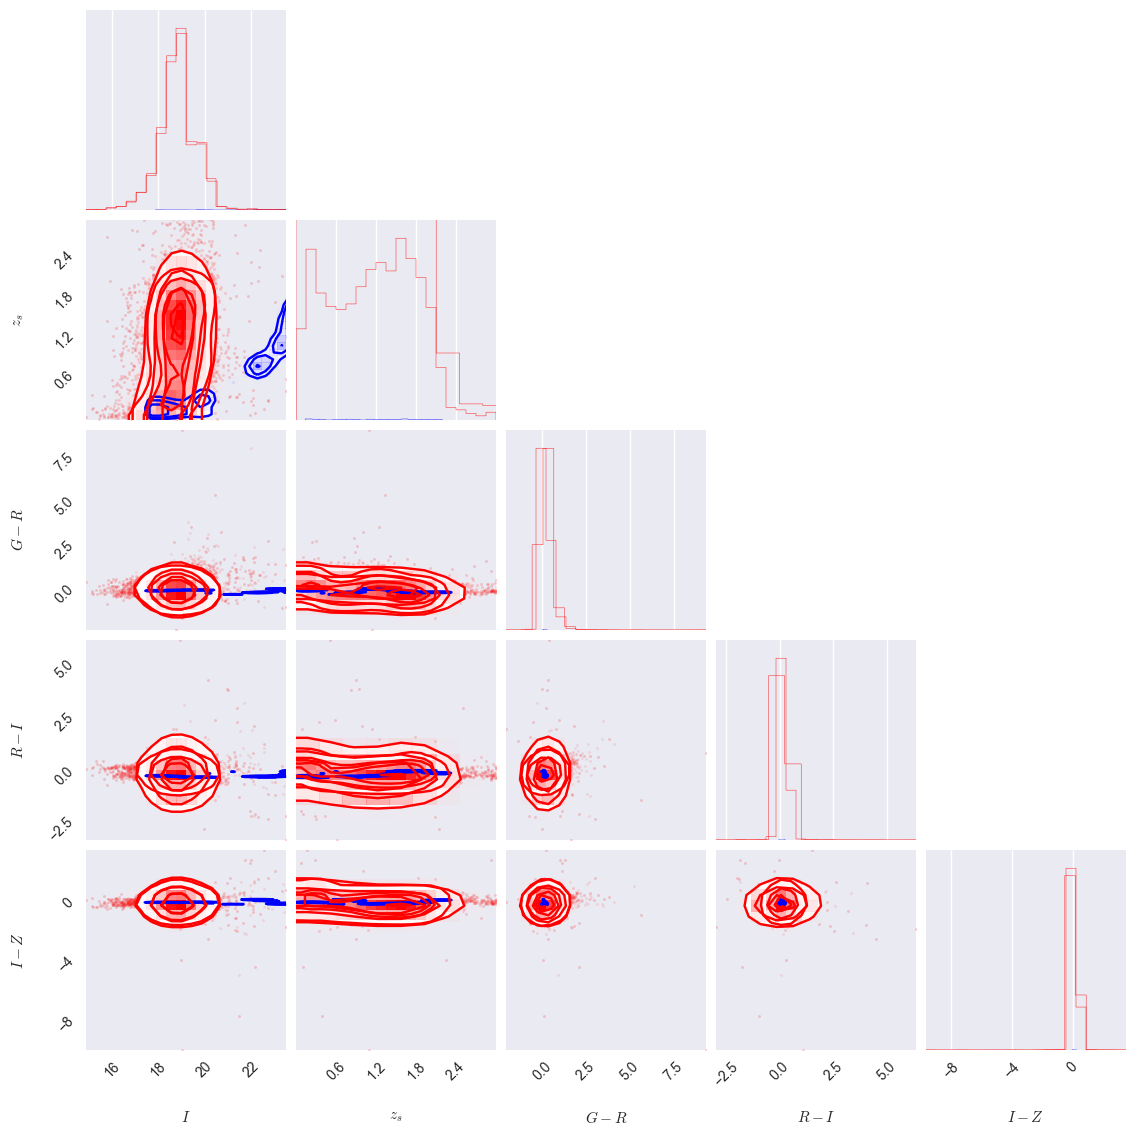

In [13]:
matplotlib.rc('text', usetex=False)
# plot the above colored lens
data = Table({'MAGI_Q': i, 'ZSRC': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
features, label = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1)

### Discussion

Red(the real data) seems to have wider distribution than the blue(synthetically colored data). The cornerplot suggests that the red(the real data) and the blue(synthetically colored data) mostly have similar average values. Red data seems to have wider distribution than the blue one, probably because of the sample size. The sample data size for the blue ones were only 50, whereas for the red ones, it was 10000.

There were some discrepancies with the i-magnitude column. However, the color index(i.e. G-R, R-I, and I-Z) values matched pretty well with the known values. This might suggest that there is some issue with the apparent magnitude calibration.

It might be helpful to more than 50 data and see how it looks like. However, as pointed in the IMagComparison notebook, it takes $\sim 1$ second per lens to calculate the magnitude. It might be better to first work on improving the efficiency of the color and then run the code again.